# Compute channel fidelity for error correction

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import qutip as qt
import numpy as np
import importlib as imp
import psutil

import channels
import codes
import recoveries
import telecorrection as tc

In [2]:
def fidelity(code, noise, recovery, decode=True):
    S = code.encoder()
    E = recovery.channel_matrix*noise.channel_matrix*S    
    if decode:
        E = code.decoder()*E
    return qt.average_gate_fidelity(E) 

# Loss and dephasing

## Run telecorrection error-correction circuit for a range of code parameters

In [13]:
%%time
imp.reload(tc)

def noise_model_kraus(kappa, kappa_n, dim):
    loss = channels.LossChannel(gamma=kappa, dim=dim, lmax=50)
    dephasing = channels.DephasingChannel(gamma=kappa_n, dim=dim, lmax=100)
    combined = channels.Channel(channel_matrix=dephasing.channel_matrix*loss.channel_matrix)
    return loss, dephasing, combined

noise_model = noise_model_kraus

N = 3 # degree of rotation symmetry
# code_param = list(range(1, 23, 1))
code_param = list(range(1, 16, 2))
print("range of code parameter:", code_param)

kappa = 1e-2 # loss rate
kappa_n = 1.0*kappa # dephasing rate
noise = None
phase_meas = None

def code_family(x):
    return codes.BinCode(N=N, M=x, fockdim=(x+2)*N)

# Ancilla parameters
M = 1 # ancilla rotation symmetry
alpha = 10
ancilla = codes.PropellerCode(N=M, r=0., alpha=alpha, fockdim=int(alpha**2 + max(36, 6*alpha)))
print('ancilla dim=', ancilla.dim)
ancilla_meas = recoveries.WedgeMeasurement(2*N*M, ancilla.dim, offset=-np.pi/(4*N*M))
ancilla.commutator_check(silent=False, atol=1e-9)
    
# Used for comparison
trivial_code = codes.TrivialCode()
trivial_recovery = channels.IdentityChannel(2)
_, _, trivial_noise = noise_model(kappa, kappa_n, 2)

fid = np.zeros((2+3, len(code_param)))
phot = np.zeros(len(code_param))

sdp = False # Find optimal recovery using SDP? Requires MATLAB and python matlab module
if sdp:
    code = code_family(code_param[0])
    sdp = recoveries.SDPRecovery(code, noise)
    
for i, x in enumerate(code_param):
    code = code_family(x)
    print(str(i+1) + '/' + str(len(code_param)),
          code.dim,
          code.codeaverage(code.number_operator),
          code.check_truncation(n=code.dim-4))
    if noise is None or code.dim != noise.sysdim:
        loss, dephasing, noise = noise_model(kappa, kappa_n, code.dim)
        no_recovery = channels.IdentityChannel(code.dim)
    if phase_meas is None or code.dim != phase_meas.sysdim:
        phase_meas = recoveries.WedgeMeasurement(4*N, code.dim, offset=-np.pi/(2*N))
    try:
        code.commutator_check(silent=True, atol=1e-6)
    except codes.CodeException as e:
        print(e)
    pg_meas = channels.PrettyGoodMeasurement(code, noise)
    measurements = [phase_meas, pg_meas]
    for j, m in enumerate(measurements):
        tcrec = tc.TeleCorrector(code, ancilla, m, ancilla_meas, code_out=None)
        c = tcrec.channel(loss, dephasing)
        fid[j, i] = qt.average_gate_fidelity(c)
    fid[2, i] = fidelity(code, noise, no_recovery)
    fid[3, i] = fidelity(trivial_code, trivial_noise, trivial_recovery)
    if sdp:
        sdp._code = code
        sdp._noise = noise
        sdp.find_recovery()
        fid[4, i] = fidelity(code, noise, sdp, decode=False)
    phot[i] = code.codeaverage(code.number_operator)
    
fid2 = fid.copy()

range of code parameter: [1, 3, 5, 7, 9, 11, 13, 15]
ancilla dim= 160
All good, buddy!
1/8 9 2.9999999999999996 0.24999999999999994


/Users/arnelg/Dropbox (Personal)/Projects/2018/propeller/public_code/recoveries.py:69: RuntimeWarning: divide by zero encountered in true_divide
  1j/(n-m)*(np.exp(1j*theta1*(n-m))
/Users/arnelg/Dropbox (Personal)/Projects/2018/propeller/public_code/recoveries.py:69: RuntimeWarning: invalid value encountered in true_divide
  1j/(n-m)*(np.exp(1j*theta1*(n-m))
/Users/arnelg/Dropbox (Personal)/Projects/2018/propeller/public_code/recoveries.py:70: RuntimeWarning: invalid value encountered in multiply
  - np.exp(1j*theta2*(n-m))))


2/8 15 5.999999999999998 0.062499999999999986
3/8 21 9.0 0.015624999999999997
4/8 27 11.999999999999996 0.003906249999999999
5/8 33 14.999999999999998 0.0009765624999999998
6/8 39 17.999999999999993 0.00024414062499999995
7/8 45 20.999999999999996 6.1035156249999986e-05
8/8 51 24.0 1.5258789062499997e-05
CPU times: user 1min 56s, sys: 1.75 s, total: 1min 58s
Wall time: 1min 56s


Text(0.5,0,'$\\langle \\hat n \\rangle$')

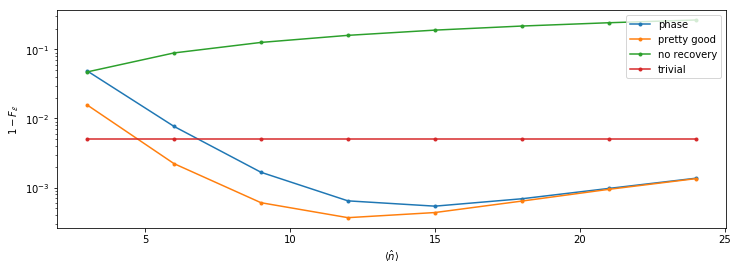

In [14]:
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(111)

legend = ['phase', 'pretty good', 'no recovery', 'trivial', 'opt']
style = ['.-', '.-', '.-', '.-', '.-']
for i in range(0, fid.shape[0] - (not sdp)):
    ax.semilogy(phot, 1-fid2[i,:], style[i], label=legend[i])
ax.legend(loc='upper right')
ax.set_ylabel(r'$1-F_\mathcal{E}$')
ax.set_xlabel(r'$\langle \hat n \rangle$')

## Plot Wigner function for a code

(-5, 5)

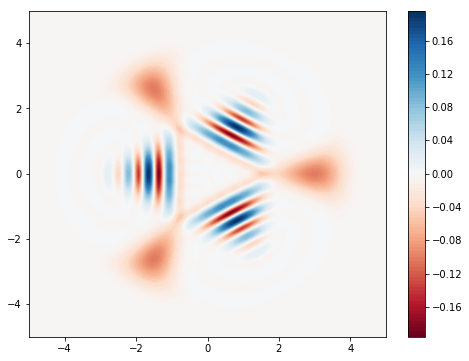

In [15]:
def wigner(rho):
    xvec = np.linspace(-10, 10, 600)
    return xvec, qt.wigner(rho, xvec, xvec)    

code = codes.BinCode(N=3, M=5, fockdim=(5+2)*3)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

rho = qt.ket2dm(code.plus)
xvec, wig = wigner(rho)
cnt1 = ax.contourf(xvec/np.sqrt(2), xvec/np.sqrt(2), -wig, 100, 
                    cmap=plt.cm.RdBu)

fig.colorbar(cnt1, ax=ax)

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])